## EDA: Sustainbench dataset

Using the [SustainBench dataset](https://github.com/sustainlab-group/sustainbench) from an interdisciplinary research group from Stanford, CalTech, and UC Berkeley. 

I'll explore and plot our data for six features, which are survey labels relevant to the UN Sustainability Goals:
- `asset_index`
- `water_index`
- `sanitation_index`
- `women_bmi`
- `women_edu`
- `under5_mort`

Out of interest, I'll also pull an additional two country-level features from geopandas:
- `gdp_md_est`
- `pop_est`

I'll look to uncover general trends in these features by country, continent, and year. I'll also see if all six SustainBench features are fit to be targets for a later ML/DL approach.

Some more questions I'd like to answer:
1. Are there any filters we need to add on this dataset, for example on year, continent, or country?
2. How does the correlation between these six features change over time? How about by country/continent?

## Results
- There are 117644 unique survey results. These results cover the years 1996-2019 and cover 56 countries in South and Central America, Southeast Asia, (mostly sub-saharan) Africa, and a couple of countries in Eastern Europe and northern Africa. 
- The indices (`asset_index`, `water_index`, `sanitation_index`) were not collected before 2004. We'll limit our downstream analyses to all data collected in 2004 or later (which consist of 86% of the original data, or ~100K rows). Removing these earlier dates reduces the missing value rate to under 20% for all potential target columns.
- `under5_mort` may not be a good target - it is incredibly sparse. 80% of its values are either NaN (10%) or 0 (70%). As a side note, it is also hardly correlated with any of the other features, likely in part due to its sparsity. In downstream analyses, we'll build models for the other five features of interest.
- India has by far the most examples - 22752 examples, or 19% of the original dataset. The vast majority of these examples were collected in 2015.
- Qualitatively, the correlation between these six features differs dramatically by geography (both by continent and by country). Though it may not be possible to build separate models per country using this small dataset, we should confirm that our model performs well across different geographies (and, for example, not just well for India, the country with by far the most examples). Specifically, I investigated correlation matrices for each continent, the top 10 most surveyed countries, and the top 10 most surveyed countries normalized by population.

In [1]:
!pip3 install pandas numpy seaborn matplotlib geopandas shapely

You should consider upgrading via the '/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('../data/dhs_final_labels.csv')
metadata = ['cname', 'year', 'lat', 'lon']
features = ['asset_index', 'women_edu', 'women_bmi', 'sanitation_index', 'water_index', 'under5_mort']
df = df[metadata+features]

df.head()

,cname,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort
0,AL,2008,40.822652,19.838321,2.430596,9.500000,24.365000,4.833333,3.444444,0.0
1,AL,2008,40.696846,20.007555,2.867678,8.600000,23.104000,4.950000,4.700000,NaN
2,AL,2008,40.750037,19.974262,2.909049,9.666667,22.387778,4.777778,4.500000,NaN
3,AL,2008,40.798931,19.863338,2.881122,9.952381,27.084500,4.789474,4.947368,NaN
4,AL,2008,40.746123,19.843885,2.546830,8.937500,24.523125,4.526316,4.684211,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117644 entries, 0 to 117643
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cname             117644 non-null  object 
 1   year              117644 non-null  int64  
 2   lat               117644 non-null  float64
 3   lon               117644 non-null  float64
 4   asset_index       86936 non-null   float64
 5   women_edu         117062 non-null  float64
 6   women_bmi         94866 non-null   float64
 7   sanitation_index  89271 non-null   float64
 8   water_index       87938 non-null   float64
 9   under5_mort       105582 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.0+ MB


In [5]:
df.describe()

,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort
count,117644.000000,117644.000000,117644.000000,86936.000000,117062.000000,94866.000000,89271.000000,87938.000000,105582.000000
mean,2010.964894,10.875259,29.263579,0.174589,6.354988,23.296365,3.086101,3.763723,18.163958
std,5.301742,16.276815,54.533060,1.848209,3.468181,2.946691,1.282027,1.123908,46.747577
min,1996.000000,-30.588811,-92.176053,-3.823164,0.000000,15.758333,1.000000,1.000000,0.000000
25%,2007.000000,0.057170,-0.137666,-1.451730,3.750000,21.148019,2.037037,3.037037,0.000000
50%,2013.000000,11.982408,32.822764,0.179011,6.333333,22.804907,2.958333,3.933333,0.000000
75%,2015.000000,24.617686,77.497416,1.842407,8.916667,24.898071,4.272727,4.826087,0.000000
max,2019.000000,48.436031,126.842321,3.607050,17.800000,48.111667,5.000000,5.000000,692.307692


In [6]:
df.isna().sum() / df.shape[0]

cname               0.000000
year                0.000000
lat                 0.000000
lon                 0.000000
asset_index         0.261025
women_edu           0.004947
women_bmi           0.193618
sanitation_index    0.241177
water_index         0.252508
under5_mort         0.102530
dtype: float64

In [7]:
df.cname.nunique()

56

In [8]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# this is a map that goes with geopandas
# it stores a country's estimated population and GDP too
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [9]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [10]:
world.describe()

,pop_est,gdp_md_est
count,1.770000e+02,1.770000e+02
mean,4.171237e+07,6.668967e+05
std,1.459691e+08,2.289440e+06
min,1.400000e+02,1.600000e+01
25%,3.360148e+06,2.581000e+04
50%,9.961396e+06,8.493000e+04
75%,2.938430e+07,4.104000e+05
max,1.379303e+09,2.114000e+07


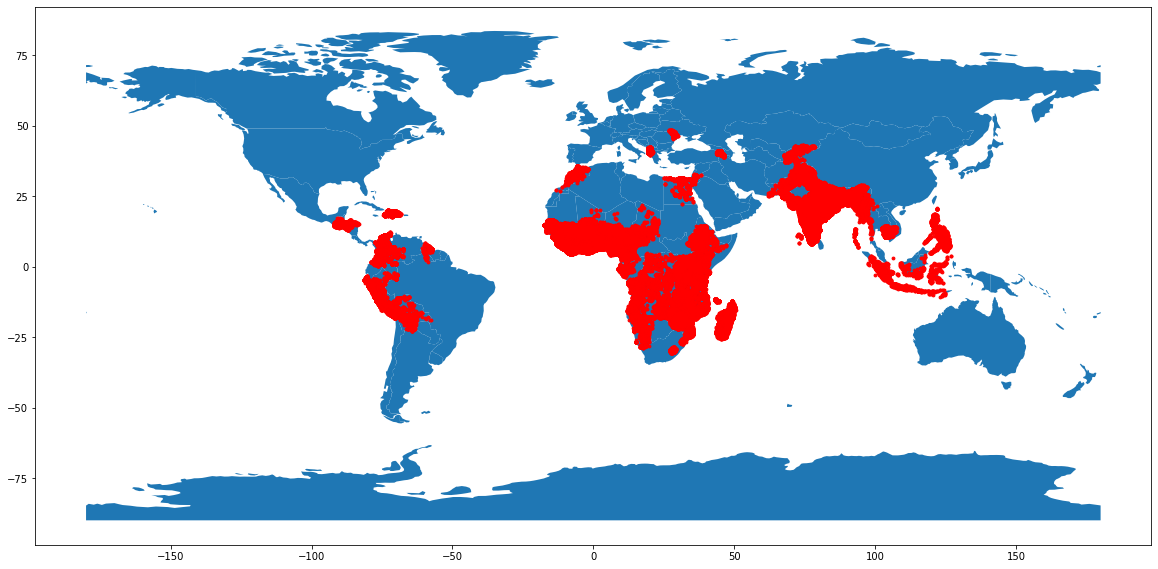

In [11]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

gdf.plot(ax=world.plot(figsize=(20, 14)), marker='o', color='red', markersize=8);

In [12]:
def assign_point_to_poly(point, polys):
    for key, poly in polys.items():
        if poly.contains(point) or poly.touches(point):
            return key
    return None

In [13]:
country_polys = dict(zip(world.name, world.geometry))
gdf['country'] = gdf.geometry.apply(lambda point: assign_point_to_poly(point, country_polys))

In [14]:
print(np.sum(gdf.country.isna()))
gdf = gdf.dropna(subset=['country'])

3332


In [15]:
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [16]:
world = world[['name', 'continent', 'pop_est', 'gdp_md_est']]
world.columns = ['country', 'continent', 'pop_est', 'gdp_md_est']
gdf = gdf.merge(world, on='country')

In [17]:
gdf.head()

,cname,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort,geometry,country,continent,pop_est,gdp_md_est
0,AL,2008,40.822652,19.838321,2.430596,9.500000,24.365000,4.833333,3.444444,0.0,POINT (19.83832 40.82265),Albania,Europe,3047987,33900.0
1,AL,2008,40.696846,20.007555,2.867678,8.600000,23.104000,4.950000,4.700000,NaN,POINT (20.00755 40.69685),Albania,Europe,3047987,33900.0
2,AL,2008,40.750037,19.974262,2.909049,9.666667,22.387778,4.777778,4.500000,NaN,POINT (19.97426 40.75004),Albania,Europe,3047987,33900.0
3,AL,2008,40.798931,19.863338,2.881122,9.952381,27.084500,4.789474,4.947368,NaN,POINT (19.86334 40.79893),Albania,Europe,3047987,33900.0
4,AL,2008,40.746123,19.843885,2.546830,8.937500,24.523125,4.526316,4.684211,0.0,POINT (19.84389 40.74612),Albania,Europe,3047987,33900.0


In [18]:
countries = list(gdf.country.unique())
continents = list(gdf.continent.unique())

In [19]:
gdf.groupby('continent')['country'].nunique().sort_values(ascending=False)

continent
Africa           49
Asia             24
South America     9
Europe            7
North America     6
Name: country, dtype: int64

In [20]:
gdf.groupby('country').size().sort_values(ascending=False)

country
India         26170
Egypt          5523
Peru           5307
Colombia       4557
Nigeria        4072
              ...  
Kazakhstan        2
Laos              2
Romania           1
Djibouti          1
Eq. Guinea        1
Length: 95, dtype: int64

<AxesSubplot:title={'center':'Boxplot for number of datapoints by year'}, xlabel='year', ylabel='Count'>

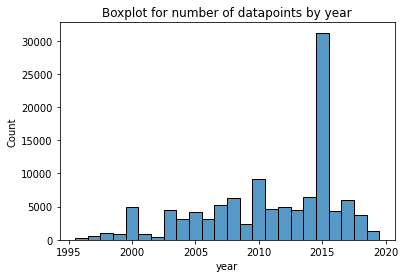

In [21]:
min_year, max_year = gdf.year.min(), gdf.year.max()

plt.figure()
plt.title(f'Boxplot for number of datapoints by year')
sns.histplot(data=gdf, x='year', binrange=(min_year, max_year), discrete=True)

In [22]:
# fet the countries and years where the most surveys were collected
gdf.dropna().groupby(['country', 'year']).size().sort_values(ascending=False)[:10]

country    year
India      2015    22635
Colombia   2010     1805
Kenya      2014     1382
Nigeria    2018     1290
Egypt      2014     1261
Peru       2009      996
Nigeria    2013      878
           2008      874
Guatemala  2015      842
Malawi     2015      738
dtype: int64

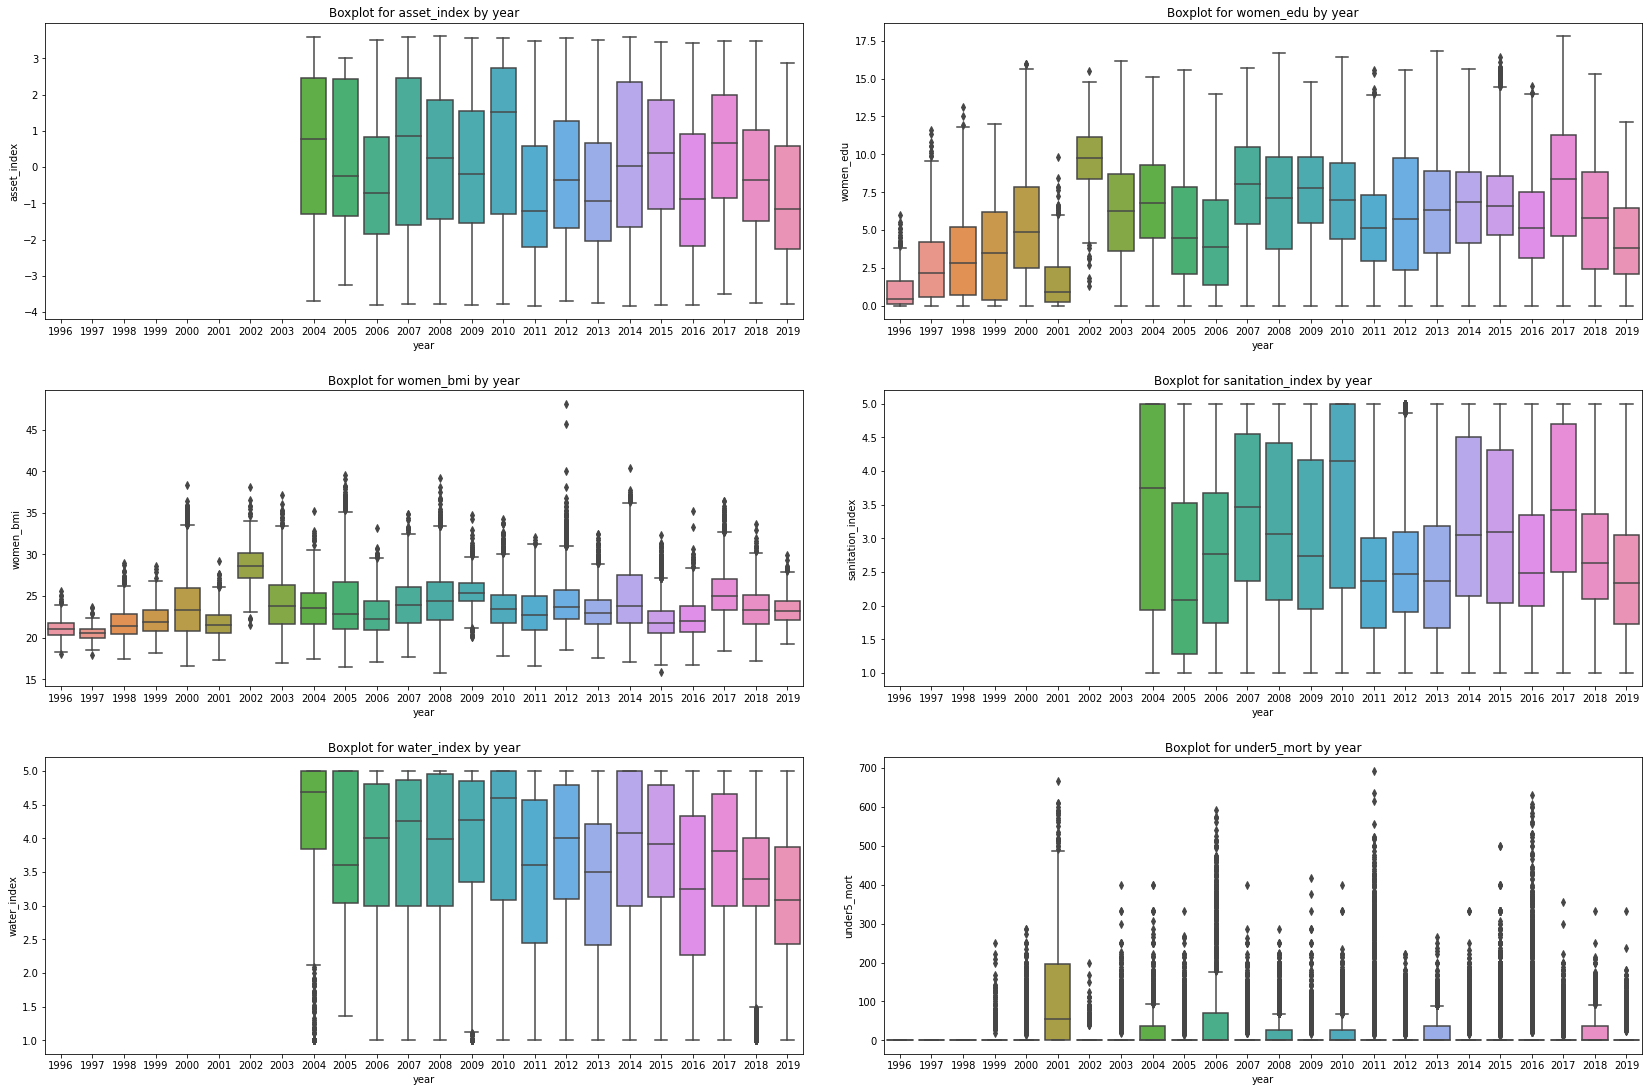

In [23]:
# any general trends by year?
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by year')
    sns.boxplot(data=gdf, x='year', y=feature, ax=ax)

In [24]:
# missing indexes before 2004, let's see how much data we lose if we only keep 2004-2019 data
print(f'There are {gdf[gdf.year > 2003].shape[0]} examples collected between 2004-2019. This constitutes {round(gdf[gdf.year > 2003].shape[0] / gdf.shape[0] * 100, 2)}% of the original data.')

There are 100673 examples collected between 2004-2019. This constitutes 88.07% of the original data.


In [25]:
# only keep 2004-2019 data
gdf = gdf[gdf.year > 2003]
gdf.describe()

,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort,pop_est,gdp_md_est
count,100673.000000,100673.000000,100673.000000,84422.000000,100146.000000,82445.000000,86729.000000,85424.000000,90214.000000,1.006730e+05,1.006730e+05
mean,2012.360484,11.327326,29.364992,0.147016,6.490405,23.226905,3.073793,3.748754,17.961607,3.680444e+08,2.477369e+06
std,3.899437,16.382863,54.264516,1.851944,3.416711,2.846176,1.284511,1.125954,45.067233,5.433475e+08,3.714532e+06
min,2004.000000,-30.588811,-92.176053,-3.823164,0.000000,15.758333,1.000000,1.000000,0.000000,5.919190e+05,2.851000e+03
25%,2010.000000,0.621788,1.699672,-1.480022,3.958333,21.159630,2.000000,3.029412,0.000000,1.466852e+07,3.972000e+04
50%,2014.000000,12.535041,33.319095,0.124672,6.444444,22.766471,2.947368,3.906250,0.000000,4.761574e+07,1.747000e+05
75%,2015.000000,24.886089,77.613529,1.817228,9.000000,24.798421,4.266667,4.818182,0.000000,1.281936e+09,8.721000e+06
max,2019.000000,48.436031,126.491681,3.607050,17.800000,48.111667,5.000000,5.000000,692.307692,1.379303e+09,2.114000e+07


In [26]:
# let's see how much missing data we have with the restricted date range
gdf.isna().sum() / gdf.shape[0]

cname               0.000000
year                0.000000
lat                 0.000000
lon                 0.000000
asset_index         0.161424
women_edu           0.005235
women_bmi           0.181061
sanitation_index    0.138508
water_index         0.151471
under5_mort         0.103891
geometry            0.000000
country             0.000000
continent           0.000000
pop_est             0.000000
gdp_md_est          0.000000
dtype: float64

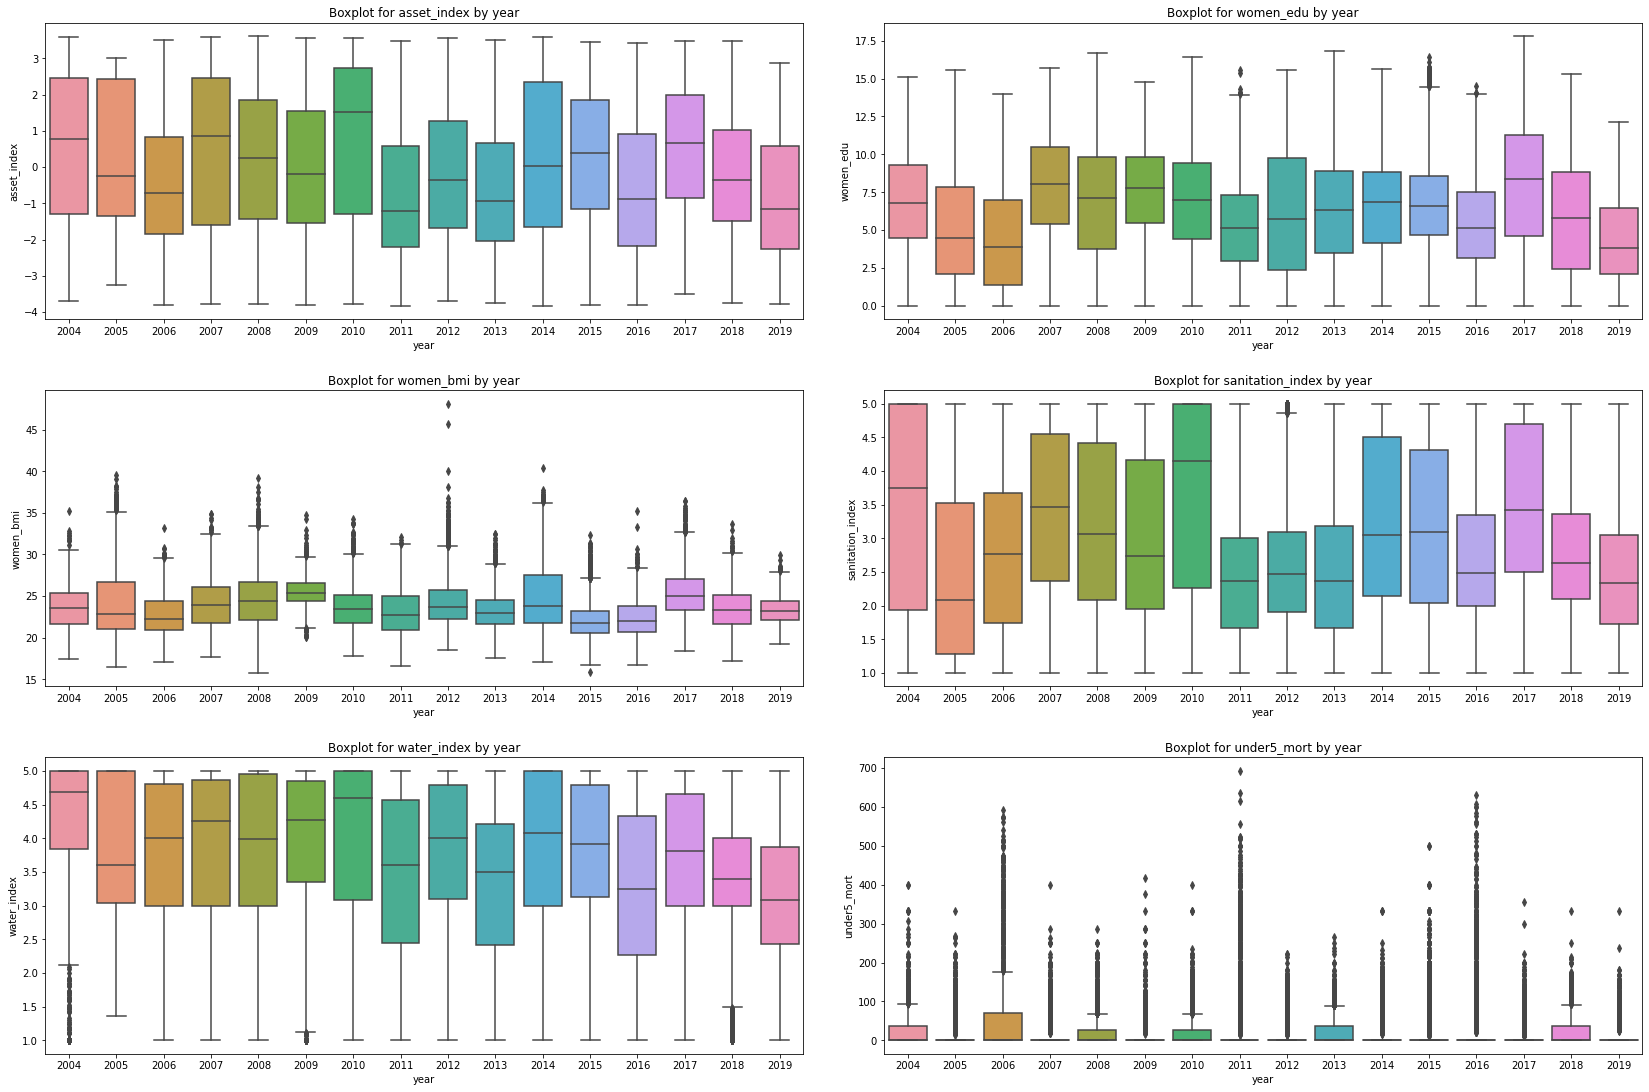

In [27]:
# and boxplots by year for the restricted date range
# difficult to get useful info out of this bc different countries/regions had data collected each year
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by year')
    sns.boxplot(data=gdf, x='year', y=feature, ax=ax)

asset_index and women_edu correlation: 0.705
asset_index and women_bmi correlation: 0.555
asset_index and sanitation_index correlation: 0.889
asset_index and water_index correlation: 0.757
asset_index and under5_mort correlation: -0.1
women_edu and women_bmi correlation: 0.485
women_edu and sanitation_index correlation: 0.665
women_edu and water_index correlation: 0.446
women_edu and under5_mort correlation: -0.142
women_bmi and sanitation_index correlation: 0.534
women_bmi and water_index correlation: 0.367
women_bmi and under5_mort correlation: -0.117
sanitation_index and water_index correlation: 0.522
sanitation_index and under5_mort correlation: -0.065
water_index and under5_mort correlation: -0.058


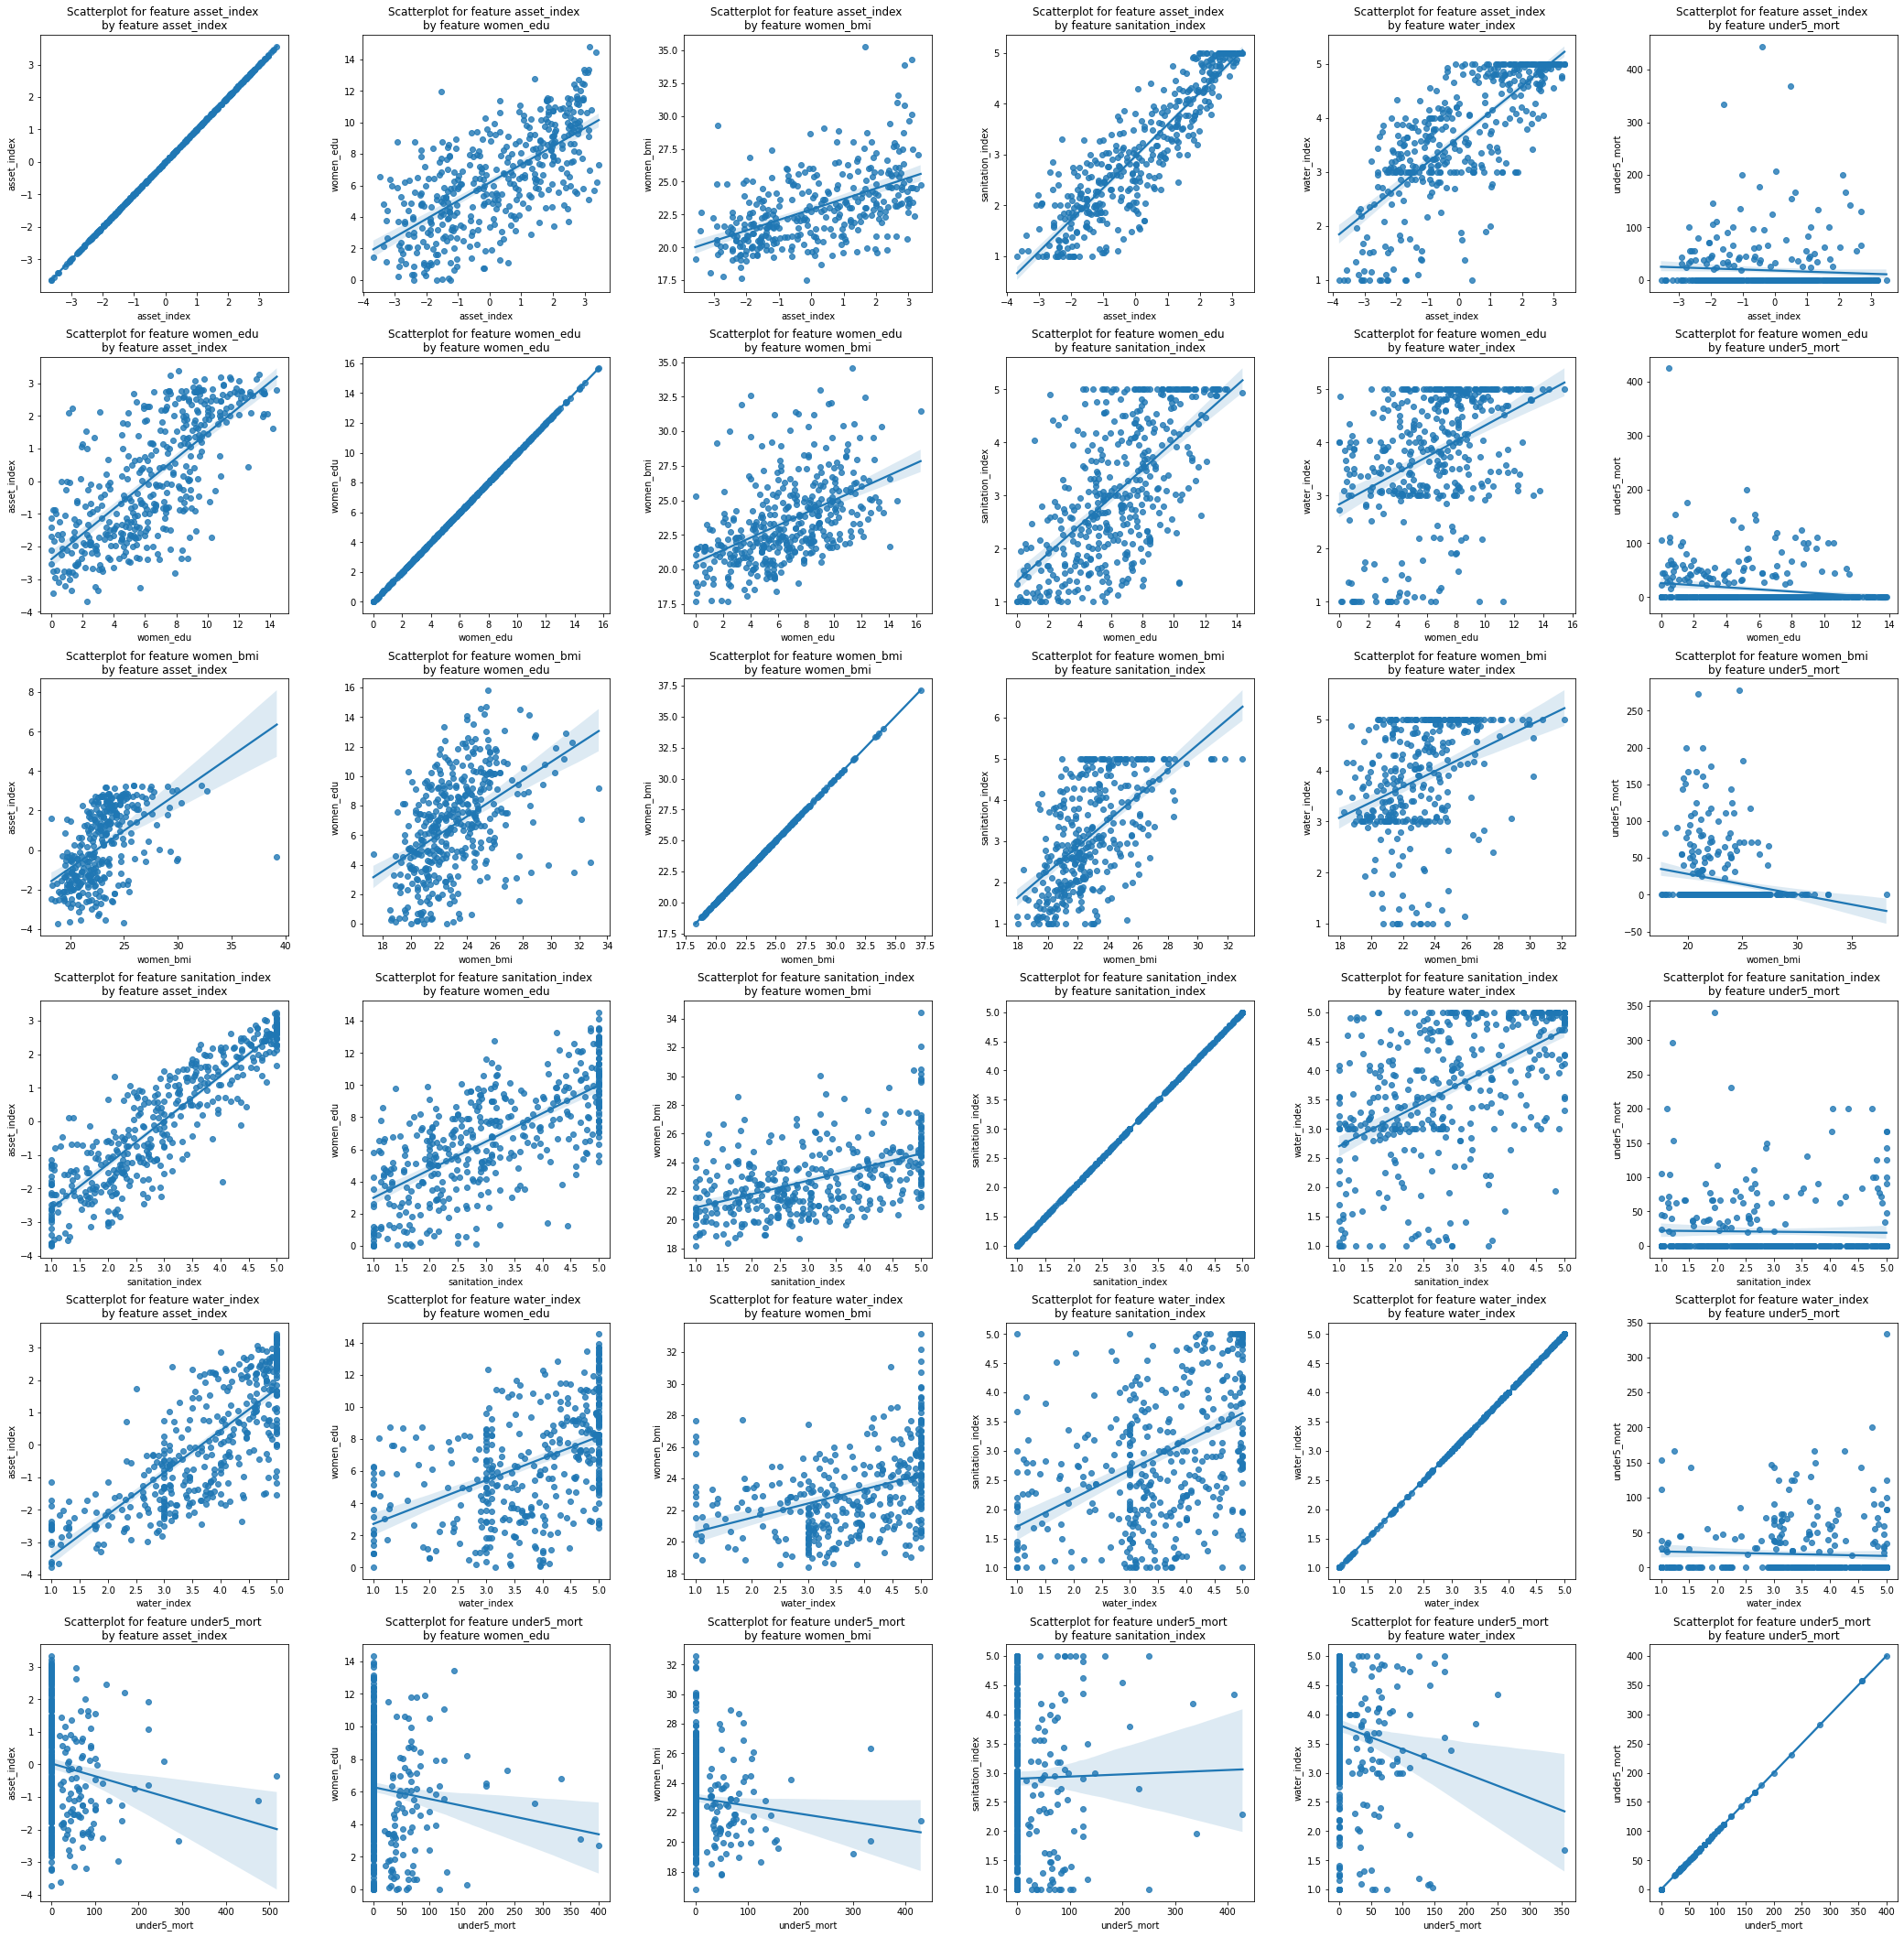

In [28]:
fig, axs = plt.subplots(len(features), len(features), figsize=(30,30))
plt.tight_layout(pad=5.0)

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        ax = axs[i][j]
        ax.set_title(f'Scatterplot for feature {feature1} \nby feature {feature2}')
        if i < j:
            print(f'{feature1} and {feature2} correlation: {round(gdf[feature1].corr(gdf[feature2]), 3)}')
        sns.regplot(data=gdf.sample(500), x=feature1, y=feature2, ax=ax)

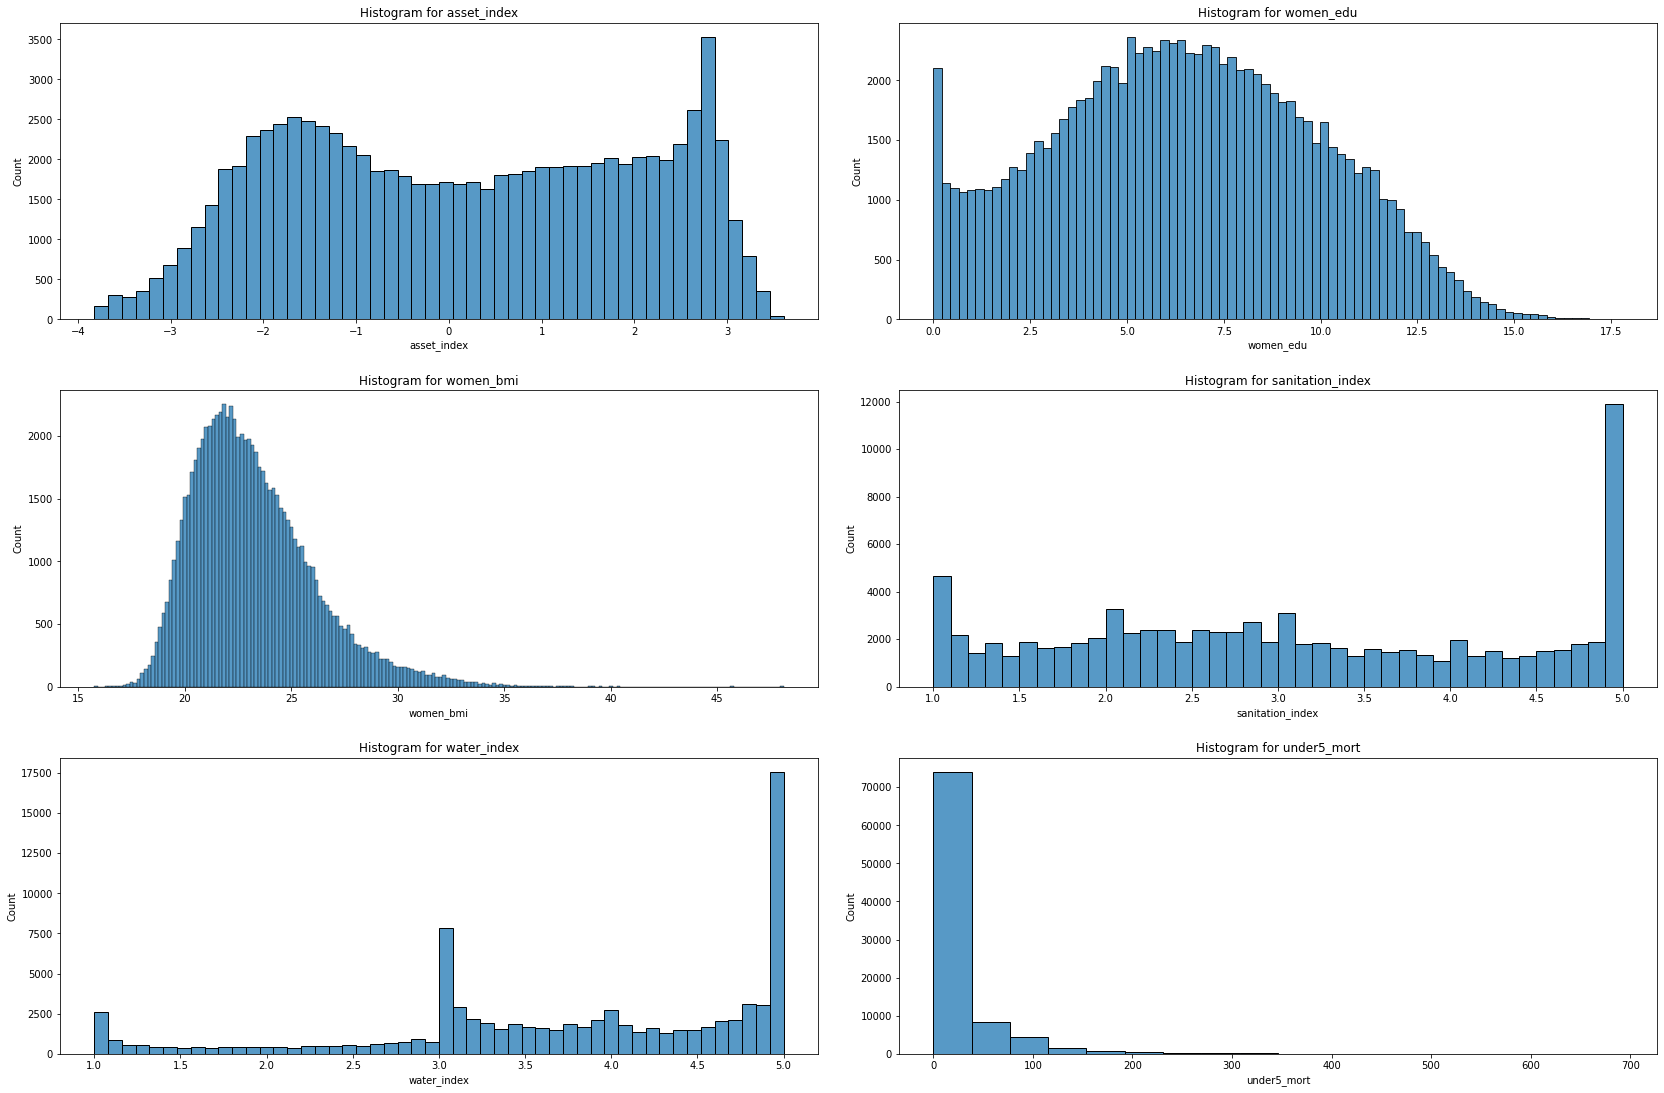

In [29]:
# distributions of each feature
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Histogram for {feature}')
    sns.histplot(data=gdf, x=feature, ax=ax)

In [30]:
# hmm, let's look at the number of values at certain cutoffs, like 0 for under5_mort
# looks like there are certain values that are arbitrary cutoffs too, like 3 for water_index
cutoff_dict = {
    'women_edu': [0],
    'under5_mort': [0],
    'sanitation_index': [1, 5],
    'water_index': [1, 3, 5],
}

for col, vals in cutoff_dict.items():
    for val in vals:
        print(f'{col} has {sum(gdf[col] == val)} examples ({round(sum(gdf[col] == val) / gdf.shape[0] * 100, 2)}% of the dataset) that are exactly equal to {val}')
    print()

women_edu has 1204 examples (1.2% of the dataset) that are exactly equal to 0

under5_mort has 69818 examples (69.35% of the dataset) that are exactly equal to 0

sanitation_index has 3597 examples (3.57% of the dataset) that are exactly equal to 1
sanitation_index has 10271 examples (10.2% of the dataset) that are exactly equal to 5

water_index has 2544 examples (2.53% of the dataset) that are exactly equal to 1
water_index has 6000 examples (5.96% of the dataset) that are exactly equal to 3
water_index has 15793 examples (15.69% of the dataset) that are exactly equal to 5



Looks like there are a few features I can binarize in this EDA:
- `asset_index` > 0 or `asset_index` < 0
- `sanitation_index` = 5 or `sanitation_index` < 5
- `water_index` = 5 or `water_index` < 5
- `under5_mort` = 0 or `under5_mort` > 0
- `women_edu` > 0 or `women_edu` = 0
- `women_bmi` seems normally distributed!

In [31]:
gdf['asset_index_bin'] = gdf['asset_index'] > 0
gdf['sanitation_index_bin'] = gdf['sanitation_index'] == 5
gdf['water_index_bin'] = gdf['water_index'] == 5
gdf['under5_mort_bin'] = gdf['under5_mort'] == 0
gdf['women_edu_bin'] = gdf['women_edu'] > 0

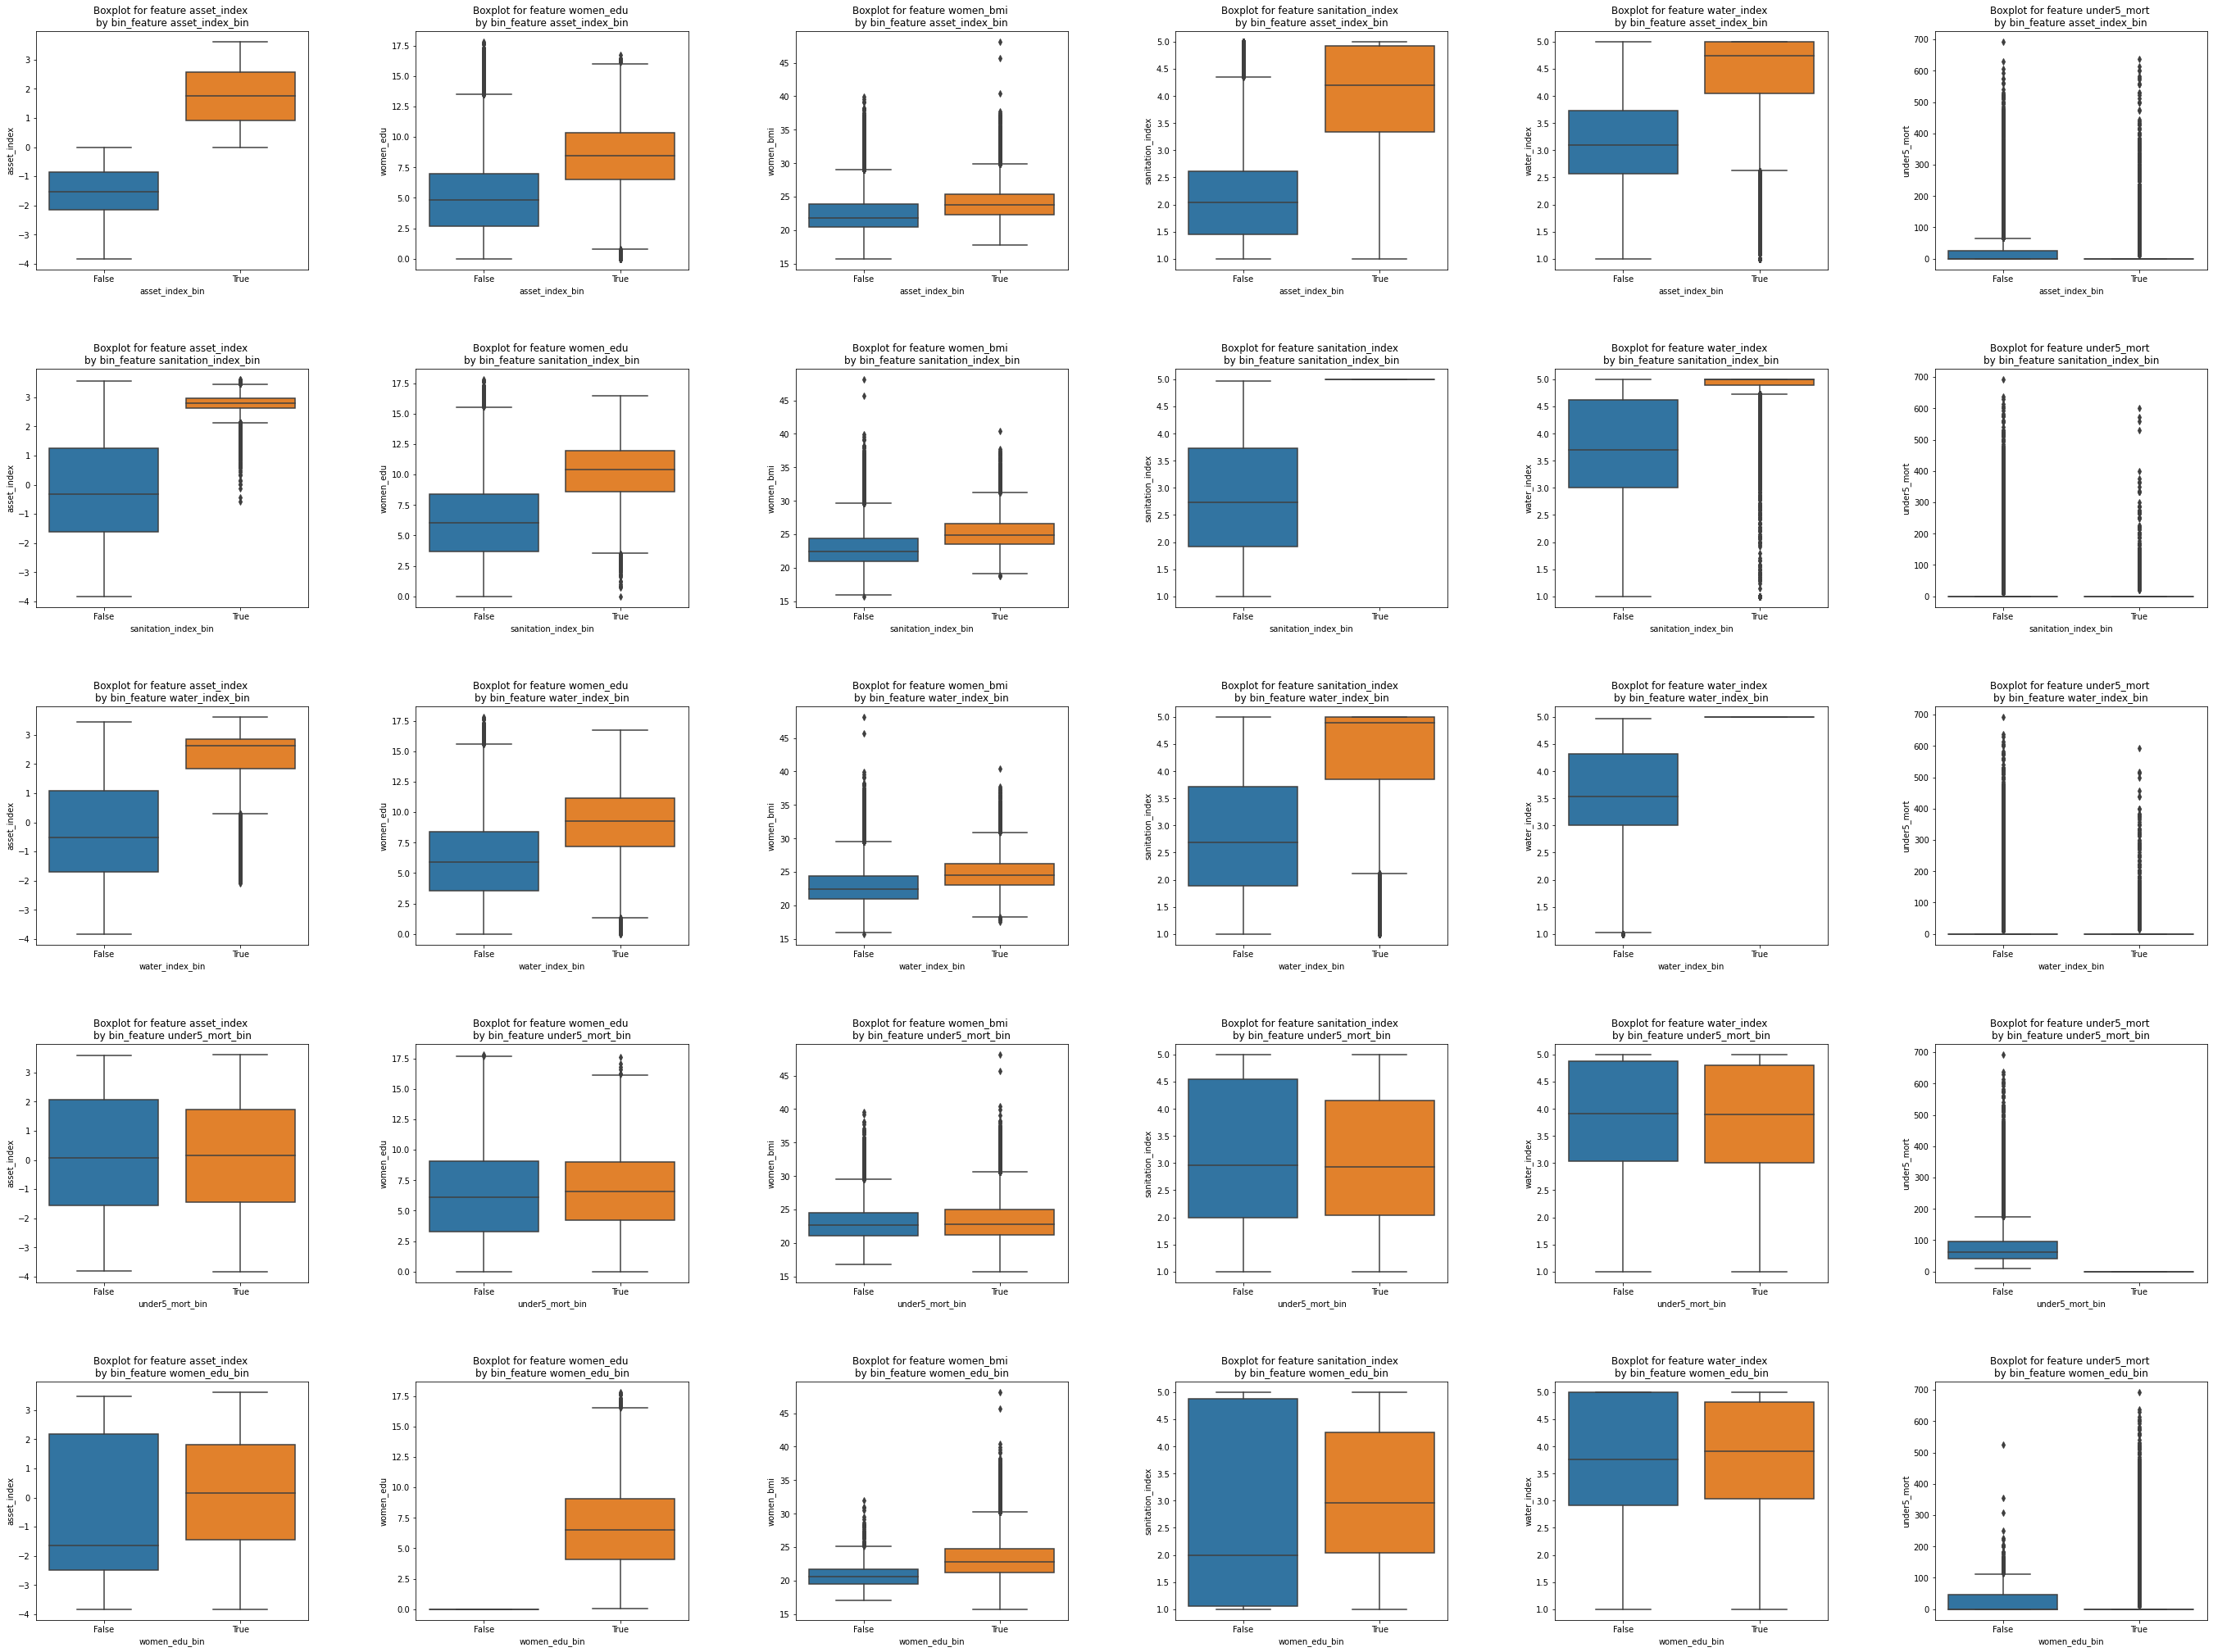

In [32]:
bin_features = ['asset_index_bin', 'sanitation_index_bin', 'water_index_bin', 'under5_mort_bin', 'women_edu_bin']
fig, axs = plt.subplots(len(bin_features), len(features), figsize=(40,30))
plt.tight_layout(pad=10.0)

for i, bin_feature in enumerate(bin_features):
    for j, feature in enumerate(features):
        ax = axs[i][j]
        ax.set_title(f'Boxplot for feature {feature} \nby bin_feature {bin_feature}')
        sns.boxplot(data=gdf, x=bin_feature, y=feature, ax=ax)

## EDA at country level

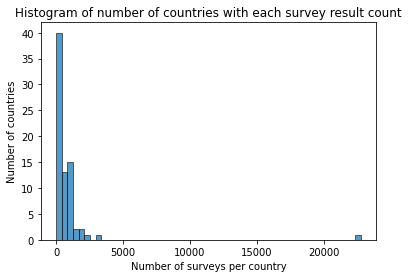

In [33]:
plt.figure()
plt.title('Histogram of number of countries with each survey result count')
plt.xlabel('Number of surveys per country')
plt.ylabel('Number of countries')
sns.histplot(gdf.dropna().groupby('country').size())
plt.show()

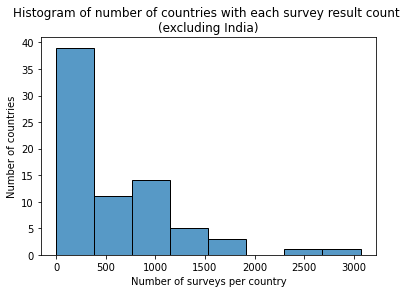

In [34]:
plt.figure()
plt.title('Histogram of number of countries with each survey result count \n(excluding India)')
plt.xlabel('Number of surveys per country')
plt.ylabel('Number of countries')
sns.histplot(gdf[gdf.country != 'India'].dropna().groupby('country').size())
plt.show()

In [35]:
n = 10
top_n_countries = gdf.dropna().groupby('country').size().sort_values(ascending=False)[:n]
top_n_countries.head(n)

country
India         22752
Nigeria        3067
Peru           2374
Colombia       1805
Kenya          1755
Bangladesh     1567
Malawi         1458
Egypt          1261
Benin          1209
Uganda         1187
dtype: int64

In [36]:
np.sum(top_n_countries.reset_index()[0]) / gdf.shape[0]

0.38178061645128286

In [37]:
top_n_countries = list(top_n_countries.reset_index()['country'])

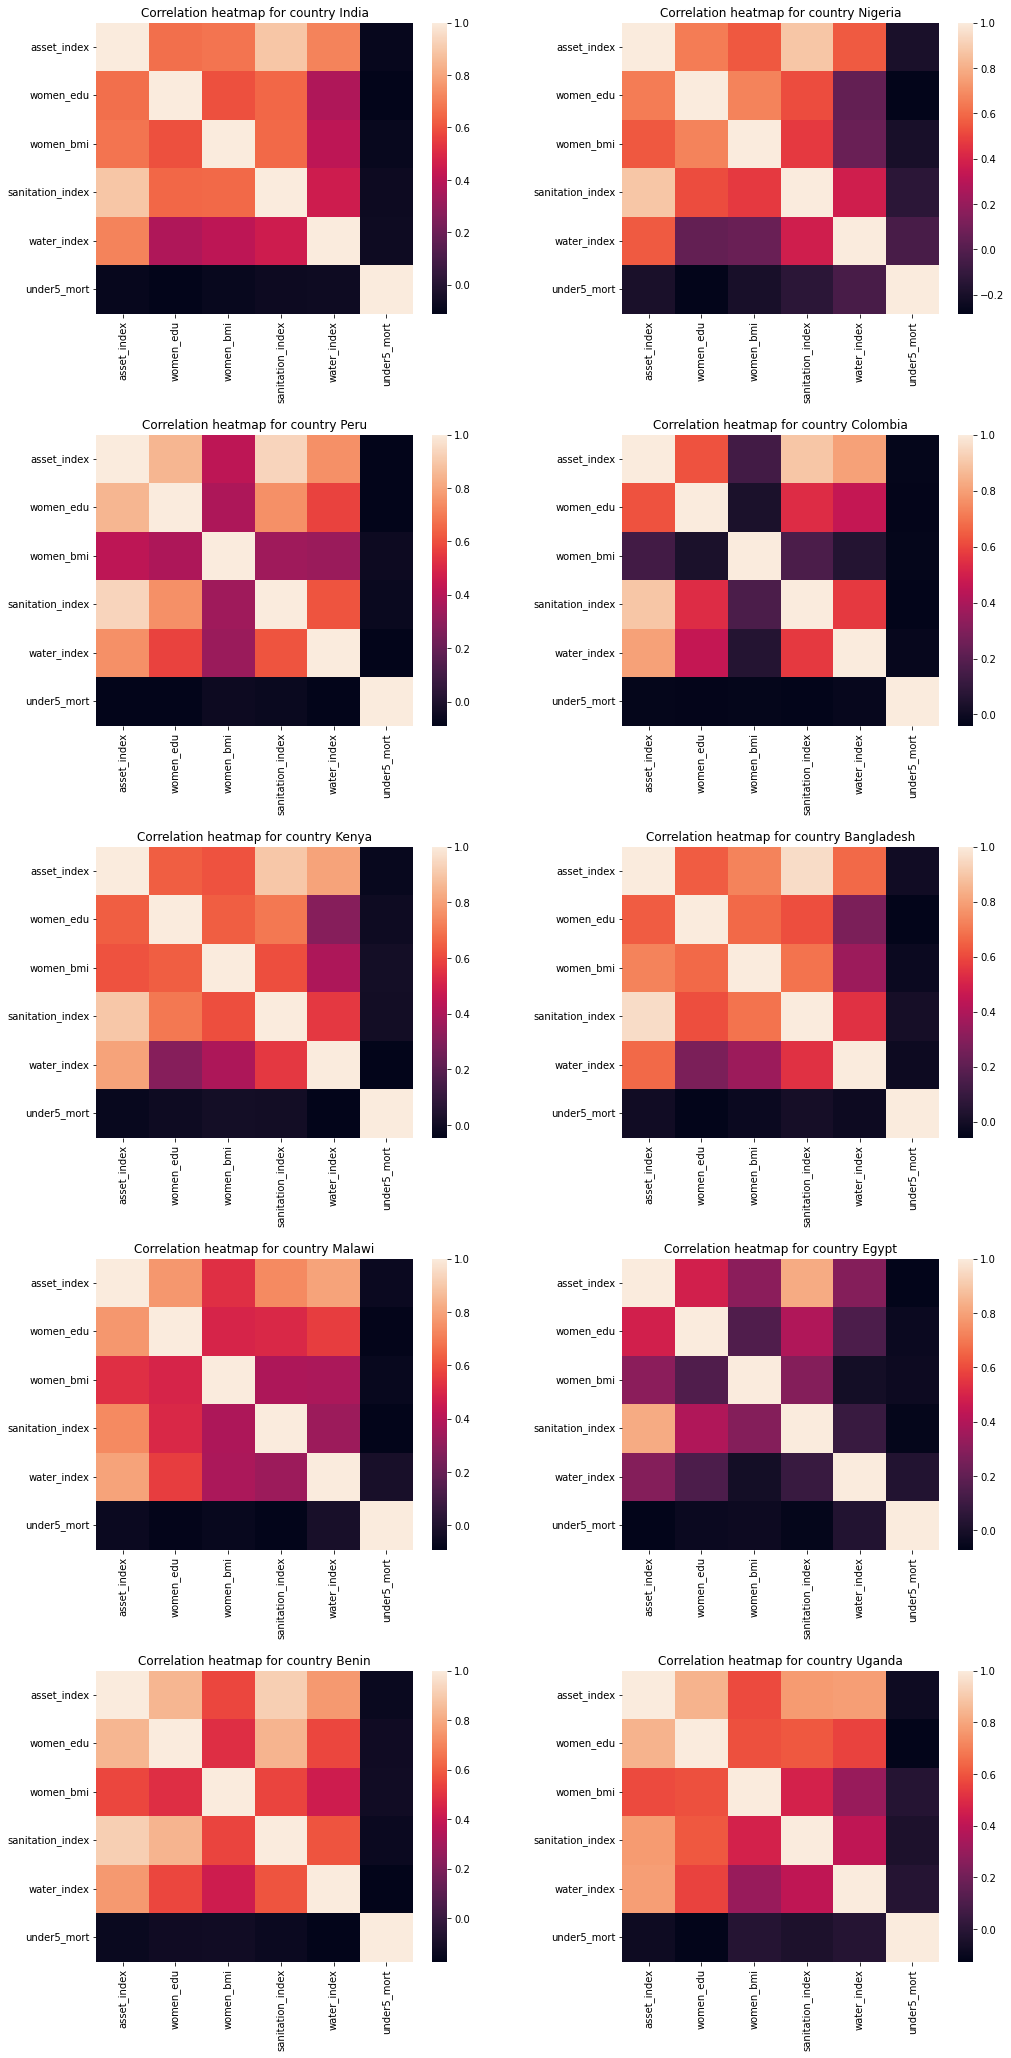

In [38]:
fig, axs = plt.subplots(5, 2, figsize=(16,30))
plt.tight_layout(pad=10.0)
axs = axs.flatten()

for i, country in enumerate(top_n_countries):
    ax = axs[i]
    ax.set_title(f'Correlation heatmap for country {country}')
    country_df = gdf[gdf.country == country][features].dropna()
    sns.heatmap(country_df.corr(), ax=ax)

In [39]:
gdf[f'in_top_{n}_surveyed_countries'] = gdf.country.isin(top_n_countries)

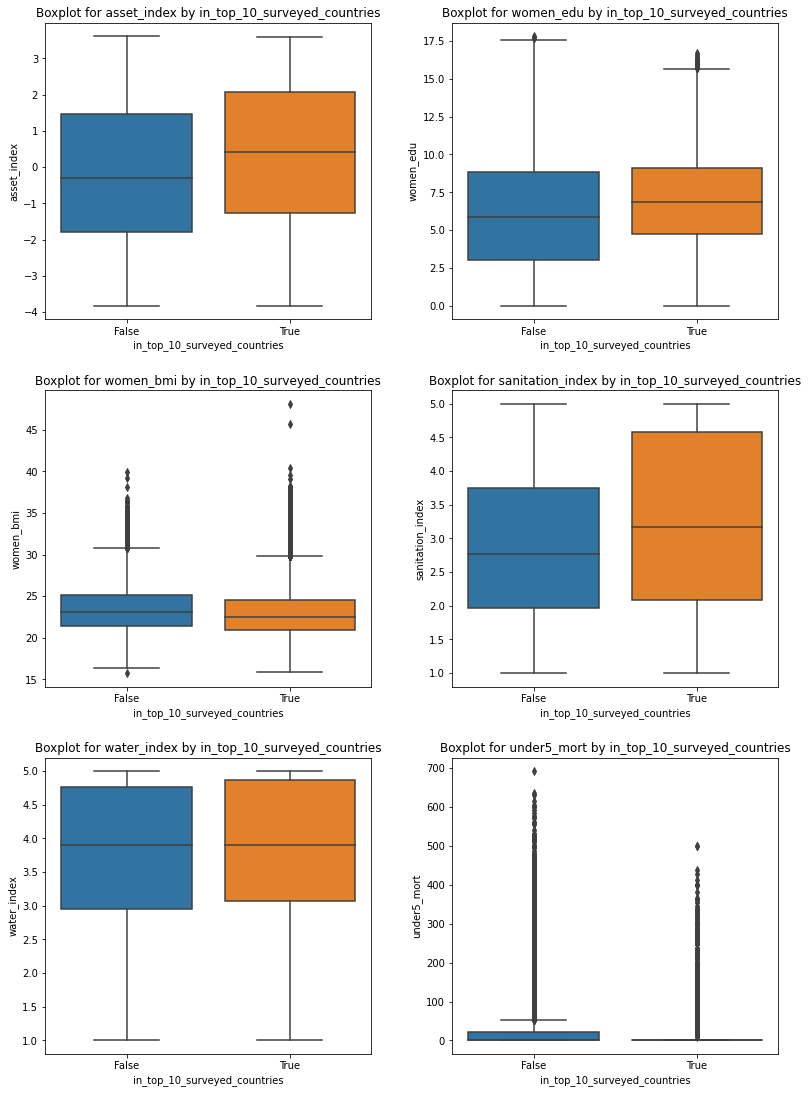

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by in_top_{n}_surveyed_countries')
    sns.boxplot(data=gdf, x=f'in_top_{n}_surveyed_countries', y=feature, ax=ax)

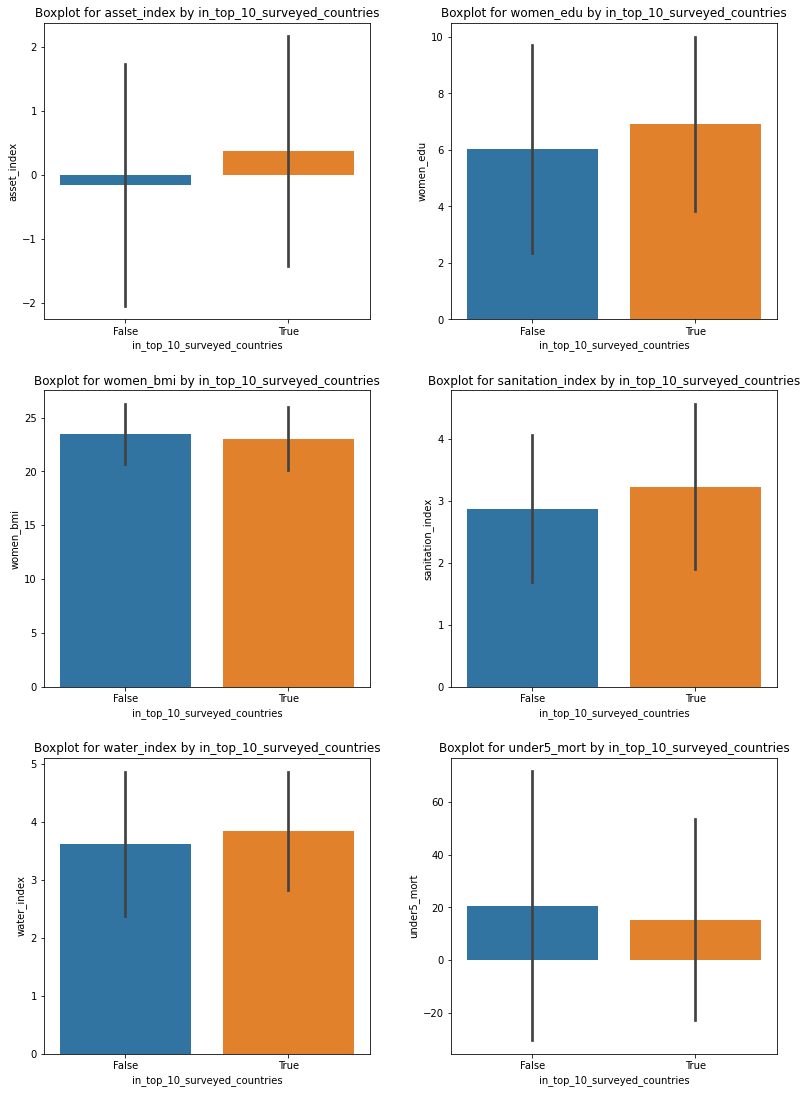

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by in_top_{n}_surveyed_countries')
    sns.barplot(data=gdf, x=f'in_top_{n}_surveyed_countries', y=feature, estimator=np.mean, ci='sd', ax=ax)

In [42]:
top_countries_normalized = gdf[['country', 'pop_est']].merge(gdf.dropna().groupby('country').size().reset_index(), on='country').drop_duplicates('country')
top_countries_normalized['normalized_size'] = top_countries_normalized[0] / top_countries_normalized['pop_est']
top_n_countries_normalized = top_countries_normalized.sort_values(by='normalized_size', ascending=False)[:n]
top_n_countries_normalized.head(n)

,country,pop_est,0,normalized_size
3645,Namibia,2484780,836,0.000336
84967,Lesotho,1958042,596,0.000304
78618,Guyana,737718,172,0.000233
74530,Liberia,4689021,848,0.000181
73056,Sierra Leone,6163195,1111,0.000180
58161,Gabon,1772255,290,0.000164
92895,eSwatini,1467152,229,0.000156
36867,Benin,11038805,1209,0.000110
64927,Haiti,10646714,1105,0.000104
91626,Zimbabwe,13805084,1133,0.000082


In [43]:
np.sum(top_n_countries_normalized.reset_index()[0]) / gdf.shape[0]

0.07478668560587248

In [44]:
top_n_countries_normalized = list(top_n_countries_normalized['country'])

In [45]:
gdf[f'in_top_{n}_surveyed_countries_normalized'] = gdf.country.isin(top_n_countries_normalized)

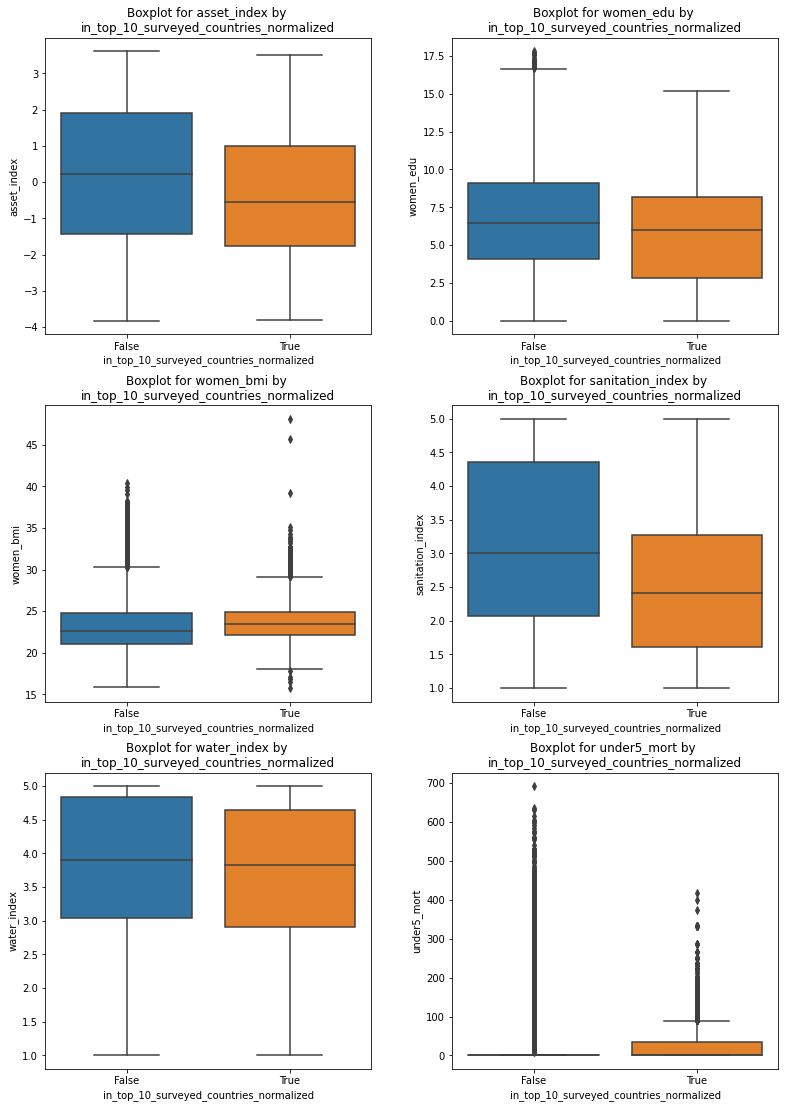

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by \nin_top_{n}_surveyed_countries_normalized')
    sns.boxplot(data=gdf, x=f'in_top_{n}_surveyed_countries_normalized', y=feature, ax=ax)

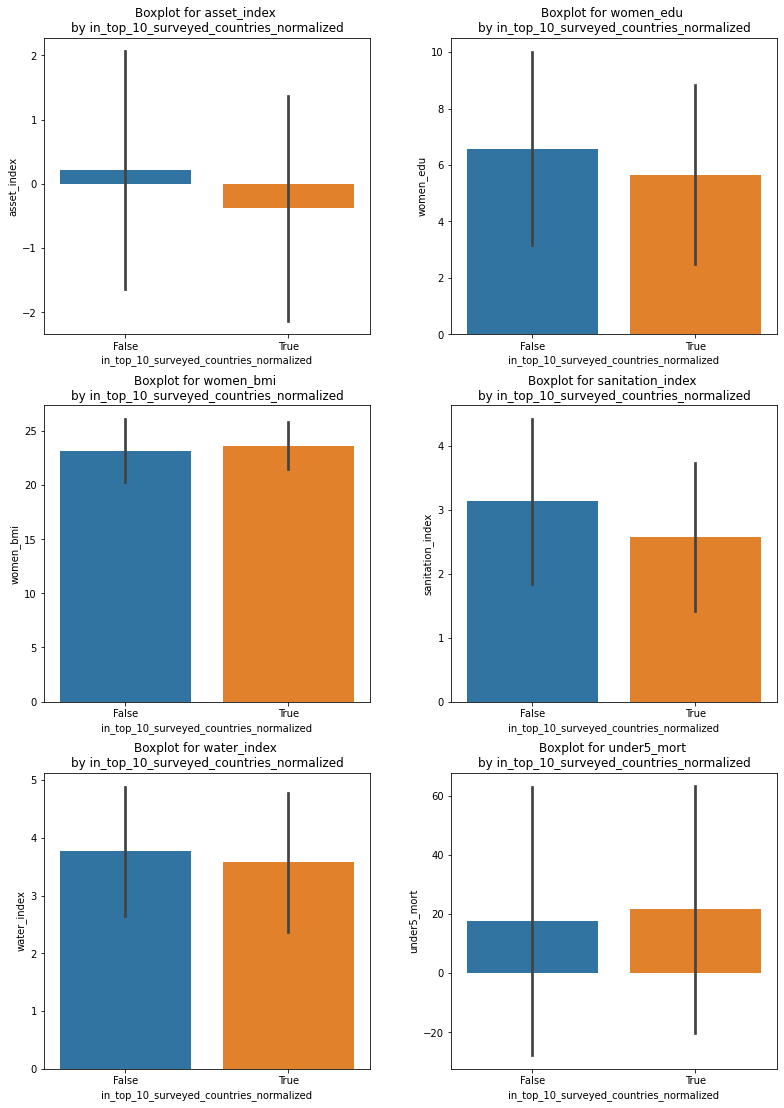

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} \nby in_top_{n}_surveyed_countries_normalized')
    sns.barplot(data=gdf, x=f'in_top_{n}_surveyed_countries_normalized', y=feature, estimator=np.mean, ci='sd', ax=ax)

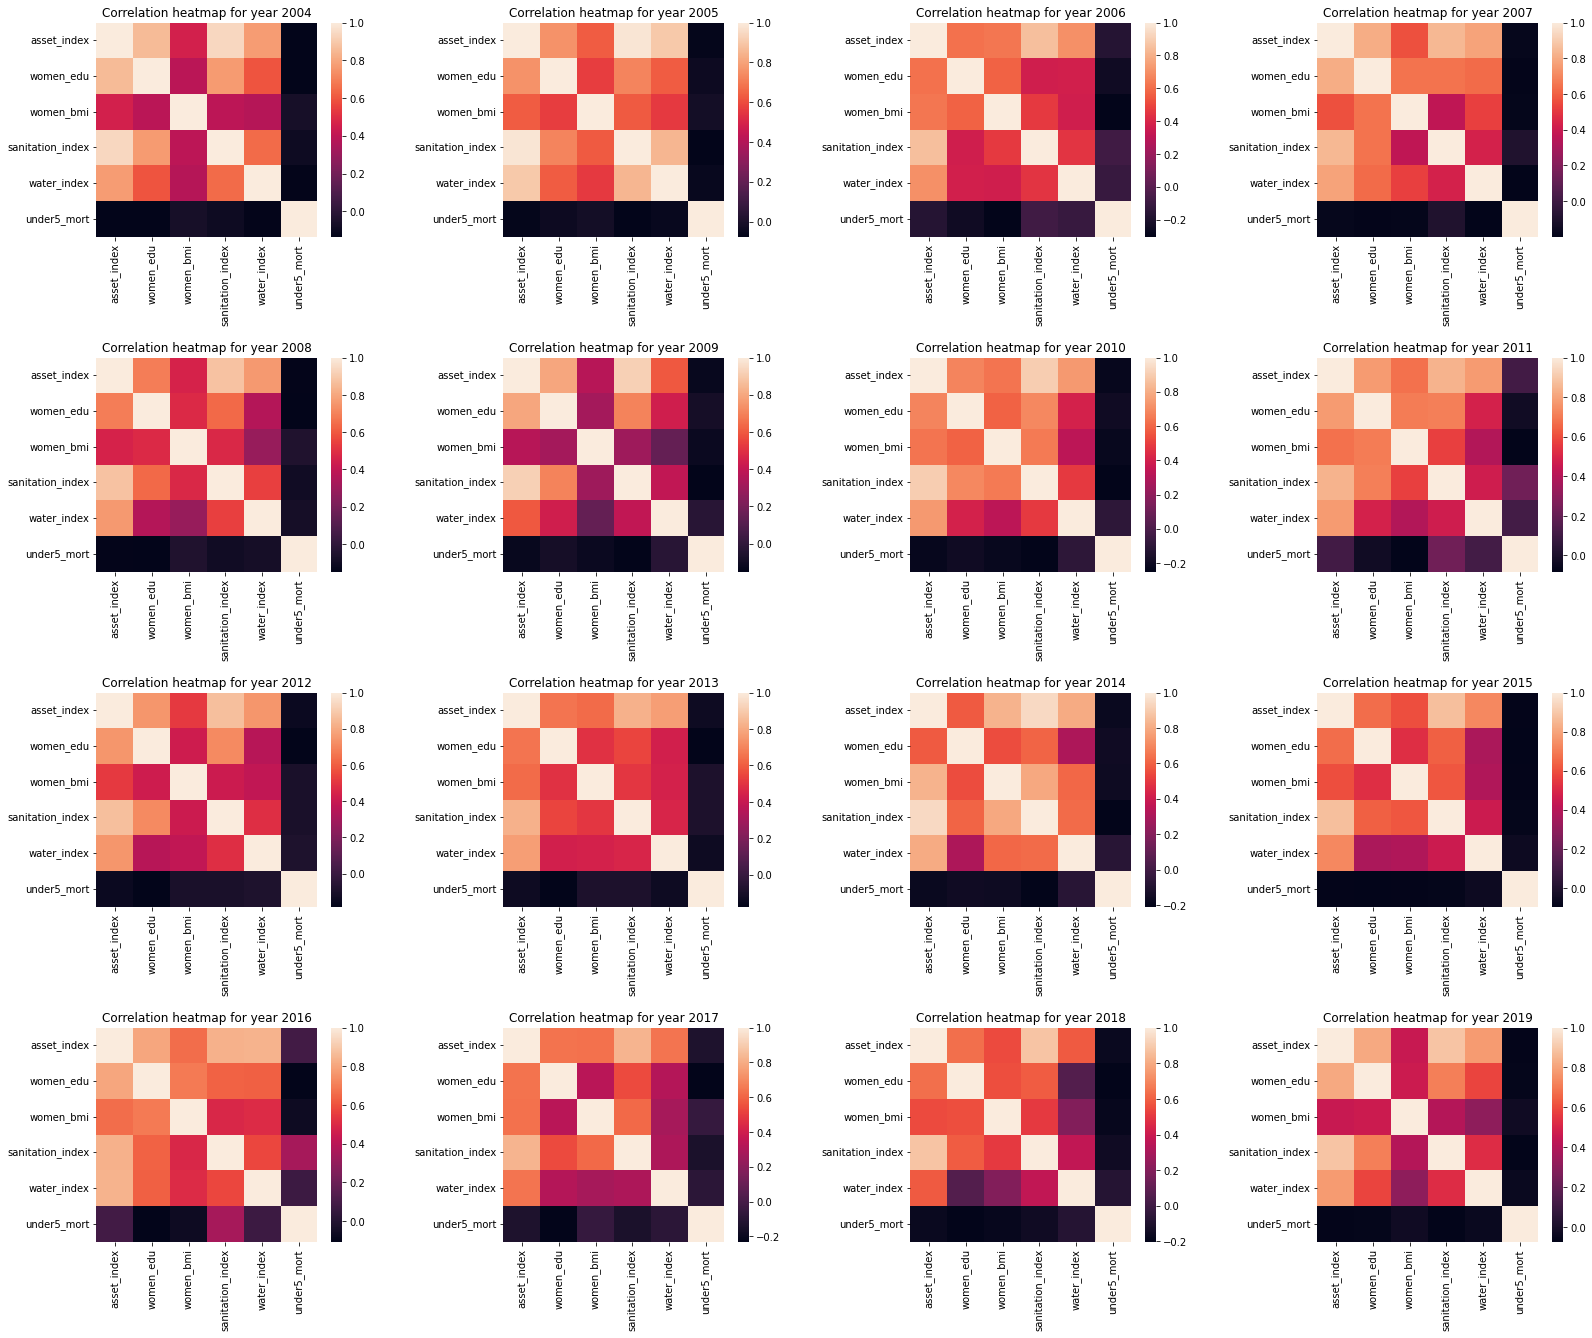

In [48]:
fig, axs = plt.subplots(4, 4, figsize=(24,20))
plt.tight_layout(pad=10.0)
axs = axs.flatten()

for i, year in enumerate(sorted(gdf.year.unique())):
    ax = axs[i]
    ax.set_title(f'Correlation heatmap for year {year}')
    year_df = gdf[gdf.year == year][features].dropna()
    sns.heatmap(year_df.corr(), ax=ax)

In [49]:
sum(gdf.under5_mort.isna()) / gdf.shape[0]

0.1038908148162864

In [50]:
sum(gdf.under5_mort > 0) / gdf.shape[0]

0.20259652538416456

## Appendix: EDA at continent level

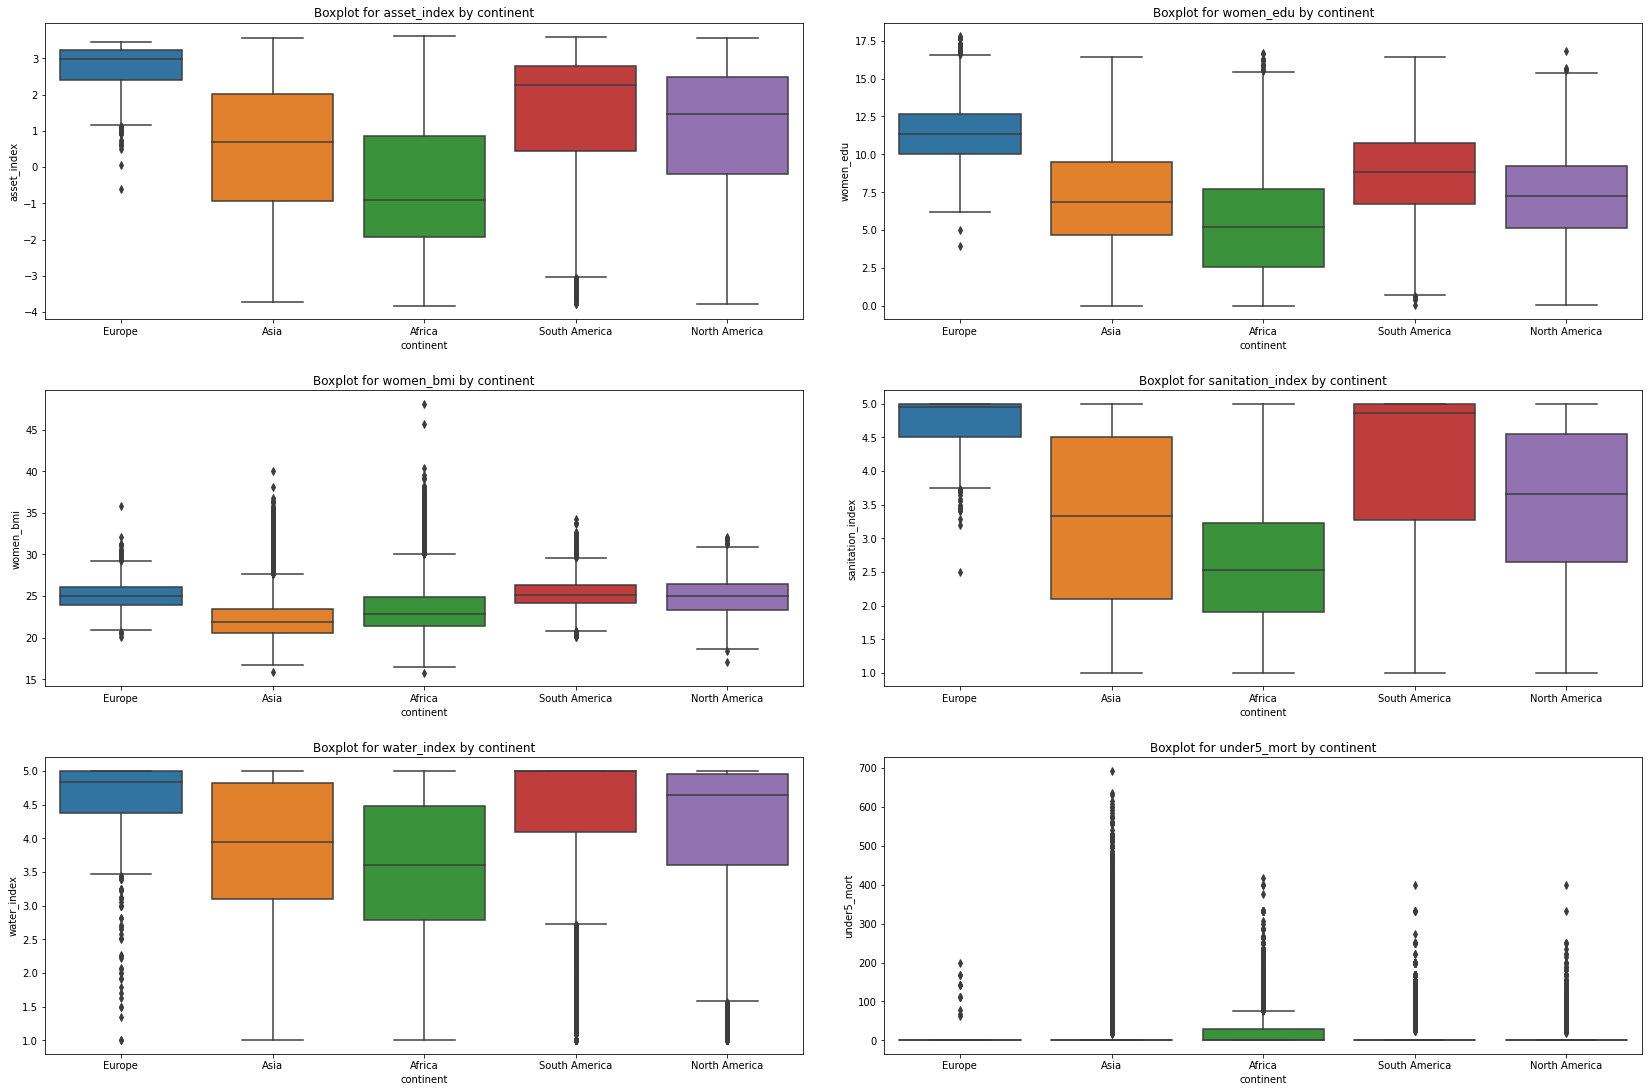

In [51]:
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by continent')
    sns.boxplot(data=gdf, x='continent', y=feature, ax=ax)

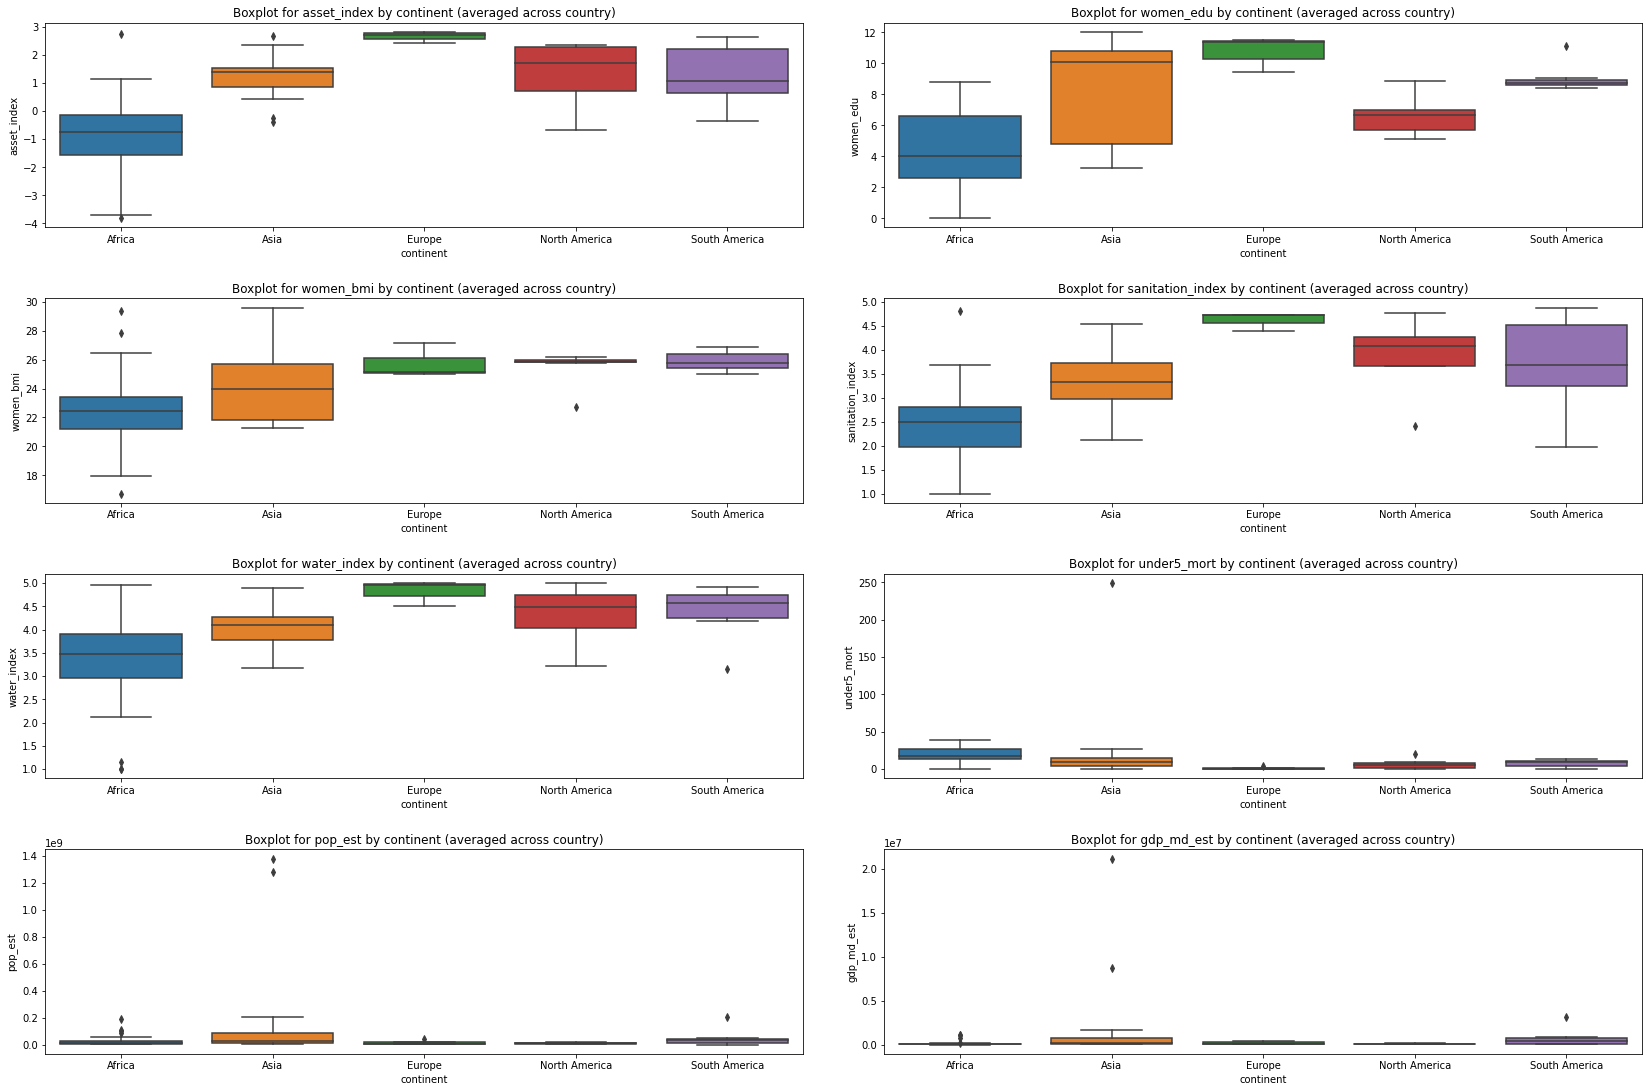

In [52]:
country_level_features = features + ['pop_est', 'gdp_md_est']

fig, axs = plt.subplots(4, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(country_level_features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by continent (averaged across country)')
    sns.boxplot(data=gdf.groupby(['continent', 'country']).mean().reset_index(), x='continent', y=feature, ax=ax)

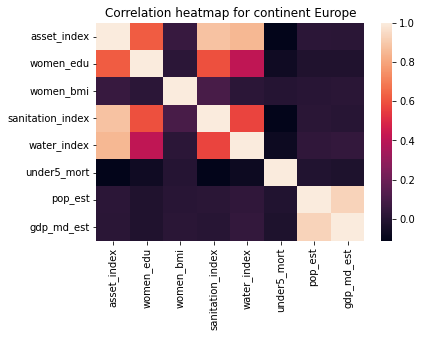

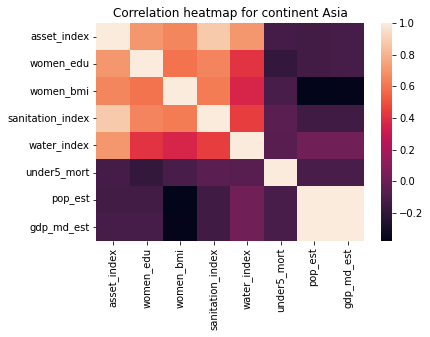

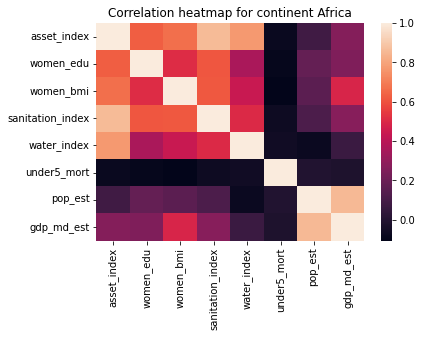

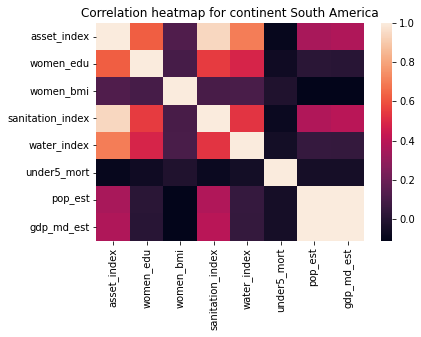

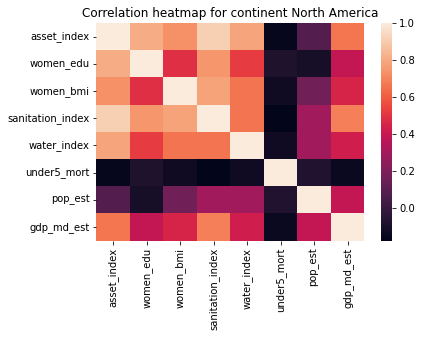

In [53]:
for continent in continents:
    plt.figure()
    plt.title(f'Correlation heatmap for continent {continent}')
    sns.heatmap(gdf[gdf.continent == continent][country_level_features].corr())